In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import json
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

In [15]:
markers = ['o', '*', 'v', '^', '<', 's']
sns.set_palette(palette=['#AC2C0C', '#3A7E5E', '#495867','#577399','#BDD5EA','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

In [16]:
# Function to calculate the total demand
def calculate_total_demand(data):
    total_demand = 0
    scenarios = data['scenarios']
    for scenario in scenarios:
        for area_data in scenario['data']:
            total_demand += sum(area_data['demand'])
    return total_demand/data['num_scenarios']

In [17]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)

results_df = pd.DataFrame()

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)

    # Calculate number of total packages
    pattern = r'^(.+?)_OC'
    base_name = re.search(pattern, file_names[i]).group(1)
    weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
    weekend_path = f'../../instances/{base_name}_dt=uniform.json'

    with open(weekday_path, 'r') as file:
        weekday = json.load(file)

    with open(weekend_path, 'r') as file:
        weekend = json.load(file)

    weekend_demand = calculate_total_demand(weekend)
    weekday_demand = calculate_total_demand(weekday)
    total_demand = weekend_demand*2 + weekday_demand*5

    # Obtain baseline results
    keys_to_keep = ['city', 'demand_baseline', 'outsourcing_cost_multiplier', 'model', 'max_n_shifts', 'workforce_size', 'wage_costs', 'objective_value', 'objective_value_post_wage']
    filtered_baseline = {key: sol['baseline'][key] for key in keys_to_keep}
    results_temp = pd.DataFrame(filtered_baseline)

    # duplicate row to store roster results
    results_temp = pd.concat([results_temp, results_temp], axis=0, ignore_index=True)
    results_temp.at[0, 'model'] =  'baseline'

    # Deal with region key inconsistency
    if 'region' in sol.keys():
        regions = sol['region']
    else:
        regions =  sol['regions']

    # Add the roster results
    wage_costs = sum( (employee, shift_start, day) in sol['r']
                    for region in regions 
                    for employee in sol['employees'][region]
                    for day in sol['days']
                    for shift_start in sol['shifts'][(region, day)])*4
    outsourcing_costs	= sol['obj_val'] - wage_costs

    results_temp.at[1, 'objective_value'] = sol['obj_val']
    results_temp['total_packages'] = total_demand
    results_temp.at[0,'cost_per_package'] = results_temp.at[0, 'objective_value']/total_demand
    results_temp.at[1,'cost_per_package'] = results_temp.at[1, 'objective_value']/total_demand
    results_temp.at[1, 'objective_value_post_wage'] = outsourcing_costs
    results_temp['outsourcing_per_package'] = results_temp['objective_value_post_wage']/total_demand
    results_temp.at[1, 'wage_costs'] = wage_costs
    results_temp['wage_cost_per_package'] = results_temp['wage_costs']/total_demand

    # Calculate percenatge of outsourcing
    results_temp['outsourcing_percentage'] = (results_temp['outsourcing_per_package'])/(results_temp['cost_per_package']*1.5)


    results_df = pd.concat([results_df, results_temp], axis=0, ignore_index=True)

# Fix model names
results_df['model'] = np.where(
    results_df['max_n_shifts'].notna() & (results_df['model'] != "baseline"),  # Condition to check non-null values
    results_df['model'] + '-' + results_df['max_n_shifts'].astype(str),  # True condition
    results_df['model']  # False condition, keep the original 'model'
)

In [18]:
results_df

,city,demand_baseline,outsourcing_cost_multiplier,model,max_n_shifts,workforce_size,wage_costs,objective_value,objective_value_post_wage,total_packages,cost_per_package,outsourcing_per_package,wage_cost_per_package,outsourcing_percentage
0,berlin,0.5,1.8,baseline,3.0,76,1983.0,2683.260000,700.260000,3071.733333,0.873533,0.227969,0.645564,0.173982
1,berlin,0.5,1.8,partflex-3.0,3.0,76,1800.0,2864.730000,1064.730000,3071.733333,0.932610,0.346622,0.585988,0.247779
2,paris,1.0,1.5,baseline,3.0,194,4141.0,4880.779808,739.779808,15578.866667,0.313295,0.047486,0.265809,0.101047
3,paris,1.0,1.5,partflex-3.0,3.0,194,4340.0,5956.957741,1616.957741,15578.866667,0.382374,0.103792,0.278583,0.180960
4,lyon,1.0,2.0,baseline,3.0,102,1990.0,2270.265926,280.265926,6092.800000,0.372615,0.046000,0.326615,0.082300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,frankfurt,4.0,1.2,fixed,NaN,342,6116.0,6779.654127,663.654127,15528.666667,0.436590,0.042737,0.393852,0.065259
796,lyon,2.0,1.8,baseline,4.0,177,3545.0,3861.843812,316.843812,12232.133333,0.315713,0.025903,0.289810,0.054696
797,lyon,2.0,1.8,partflex-4.0,4.0,177,4052.0,4336.572073,284.572073,12232.133333,0.354523,0.023264,0.331259,0.043748
798,lyon,2.0,2.0,baseline,NaN,177,3563.0,3896.082013,333.082013,12232.133333,0.318512,0.027230,0.291282,0.056994


# Cost Graphs

In [19]:
models_textsc = {
    'baseline': '\\textsc{MBase}',
    'flex': '\\textsc{Flex}',
    'partflex-4.0': '\\textsc{PartFlex} ($\\mu = 4$)',
    'partflex-3.0': '\\textsc{PartFlex} ($\\mu = 3$)',
    'partflex-2.0': '\\textsc{PartFlex} ($\\mu = 2$)',
    'fixed': '\\textsc{Fixed}'
}

In [20]:
def add_fig_legend(fig, bbox_to_anchor=(.5,-0.095)):
    elements = [
        (
            Patch(facecolor='C0', edgecolor='C0'),
            Line2D([0], [0], color='C0', marker=markers[0], markersize=8)
        ),
        (
            Patch(facecolor='C1', edgecolor='C1'),
            Line2D([0], [0], color='C1', marker=markers[1], markersize=8)
        ),
        (
            Patch(facecolor='C2', edgecolor='C2'),
            Line2D([0], [0], color='C2', marker=markers[2], markersize=8)
        ),
        (
            Patch(facecolor='C3', edgecolor='C3'),
            Line2D([0], [0], color='C3', marker=markers[3], markersize=8)
        ),
        (
            Patch(facecolor='C4', edgecolor='C4'),
            Line2D([0], [0], color='C4', marker=markers[4], markersize=8)
        ),
        (
            Patch(facecolor='C5', edgecolor='C5'),
            Line2D([0], [0], color='C5', marker=markers[5], markersize=8)
        ),
        Patch(facecolor='white', edgecolor='black'),
        Patch(facecolor='white', edgecolor='black', hatch='\\\\')
    ]
    
    fig.legend(
        handles=elements, handler_map={tuple: HandlerTuple(ndivide=2)},
        labels=[
            '\\textsc{MBase}', '\\textsc{Flex}', '\\textsc{PartFlex} ($\\mu = 4$)', '\\textsc{PartFlex} ($\\mu = 3$)', '\\textsc{PartFlex} ($\\mu = 2$)',
            '\\textsc{Fixed}', 'Outsourcing Costs', 'Hiring costs'
        ],
        fontsize=14, loc='lower center', bbox_to_anchor=bbox_to_anchor,
        ncols=4, handlelength=5, frameon=False
    )

    return fig

## Cost overview

In [21]:
def plot_cost_overview():
    plt.rcParams['hatch.linewidth'] = 2

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]
    
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    # Boxplot
    sns.boxplot(data=results_df, x='model', y='cost_per_package', order=models, hue='model', hue_order=models, fliersize=0, ax=ax, palette=sns.color_palette())
    ax.set_ylim((0, results_df['cost_per_package'].quantile(0.999)))
    ax.set_ylabel('Avg cost per parcel', fontsize=16)
    ax.set_xlabel('')


    for idx, model in enumerate(models):
        avg =  results_df[results_df['model'] == model]['cost_per_package'].median()
        ax.text(x=idx, y=avg, s=f"{avg:.2f}", va='bottom', ha='center', color='white', fontsize=16, fontweight='bold')


    ax = axes.flat[1]

    # Barplot

    ticks = range(len(models))
    ax.bar(
        x=ticks,
        height = results_df.groupby('model', observed=True)['wage_cost_per_package'].mean(),
        color=[f"C{i}" for i in ticks],
        linewidth=2,
        edgecolor='white')

    first_patches = ax.patches[:]

    ax.bar(
        x=ticks,
        height = results_df.groupby('model', observed=True)['wage_cost_per_package'].mean(),
        bottom=results_df.groupby('model', observed=True)['outsourcing_per_package'].mean(),
        color=[f"C{i}" for i in ticks],
        linewidth=2,
        edgecolor='white'
    )

    for bar in ax.patches:
        if bar in first_patches:
            continue
        bar.set_hatch('\\')

    ax.set_ylim((0, 1))
    ax.set_xticks(ticks)
    ax.set_xticklabels(models)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.axes.set_axisbelow(True)
    ax.set_xlabel('')

    ax.legend(handles=[
        Patch(facecolor='white', edgecolor='black', label='Outsourcing costs'),
        Patch(facecolor='white', edgecolor='black', hatch='\\\\', label='Hiring costs')
    ], loc='upper center', ncols=2, frameon=False, fontsize=16)

    for ax in axes.flat:
        ticklabels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        ticklabels = [models_textsc[lbl] for lbl in ticklabels]
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ticklabels, fontsize=16)

        for tl in ax.get_xticklabels():
            tl.set_rotation_mode('anchor')
            tl.set_rotation(45)
            tl.set_ha('right')
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

    fig.tight_layout()
    fig.savefig('figures/cost_overview.pdf', dpi=96, bbox_inches='tight')

    return fig, axes

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: ylabel='Avg cost per parcel'>,
        <Axes: ylabel='Avg cost per parcel'>], dtype=object))

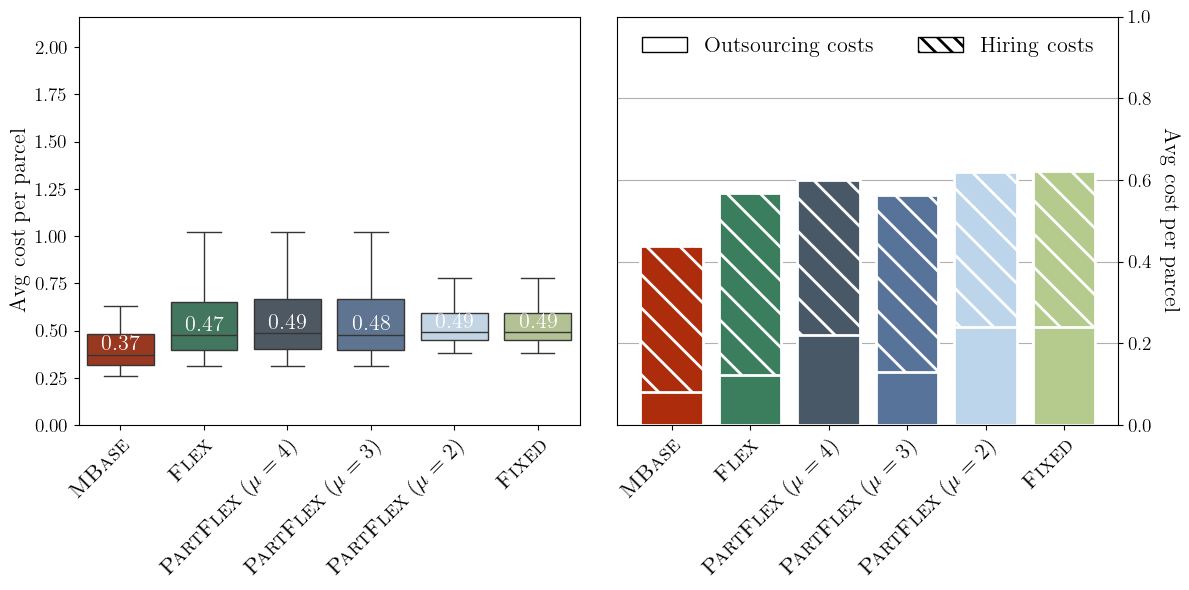

In [22]:
plot_cost_overview()

## Impact of the demand baseline

In [23]:
def plot_db_impact():
    plt.rcParams['hatch.linewidth'] = 1

    db_values = [0.5, 1.0, 2.0, 4.0]
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]

    sns.lineplot(
        data=results_df, x='demand_baseline', y='outsourcing_percentage',
        hue='model', style='model',
        errorbar=None, markers=markers, dashes=False, ax=ax , palette=sns.color_palette())
    ax.legend().set_visible(False)
    ax.axes.set_axisbelow(True)
    ax.axes.set_xticks(db_values)
    ax.set_xlabel('\\texttt{DB}', fontsize=16)
    ax.set_ylabel('Parcels outsourced (\\%)', fontsize=16)

    for db in db_values:
        ax.axvline(x=db, linestyle='--', color='black', linewidth=0.5, alpha=0.25)

    ax = axes.flat[1]

    n_models = 6
    n_db = len(db_values)

    ticks = [(x1 + x2) / 2 for x1, x2 in zip(range(1, n_db* n_models, n_models + 1), range(n_models, n_db * (n_models + 1), n_models + 1))]

    for db_idx, db in enumerate(db_values):
        for model_idx, model_long in enumerate(models):
            bar_x = db_idx * (n_models + 1) + model_idx + 1
            data = results_df[(results_df['demand_baseline'] == db) & (results_df['model'] == model_long)]
            hc = data['wage_cost_per_package'].mean()
            oc = data['outsourcing_per_package'].mean()

            ax.bar(x=[bar_x], height=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white')
            ax.bar(x=[bar_x], height=[hc], bottom=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white', hatch='\\')


    ax.set_xticks(ticks)
    ax.set_xticklabels(db_values)
    ax.set_xlabel('\\texttt{DB}', fontsize=16)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.set_axisbelow(True)
    ax.tick_params(which='major', axis='x', length=0)

    for ax in axes.flat:
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

    add_fig_legend(fig, bbox_to_anchor=(0.5, -0.15))

    fig.tight_layout()
    fig.savefig('figures/db.pdf', dpi=96, bbox_inches='tight')

    return fig, axes

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: xlabel='\\texttt{DB}', ylabel='Parcels outsourced (\\%)'>,
        <Axes: xlabel='\\texttt{DB}', ylabel='Avg cost per parcel'>],
       dtype=object))

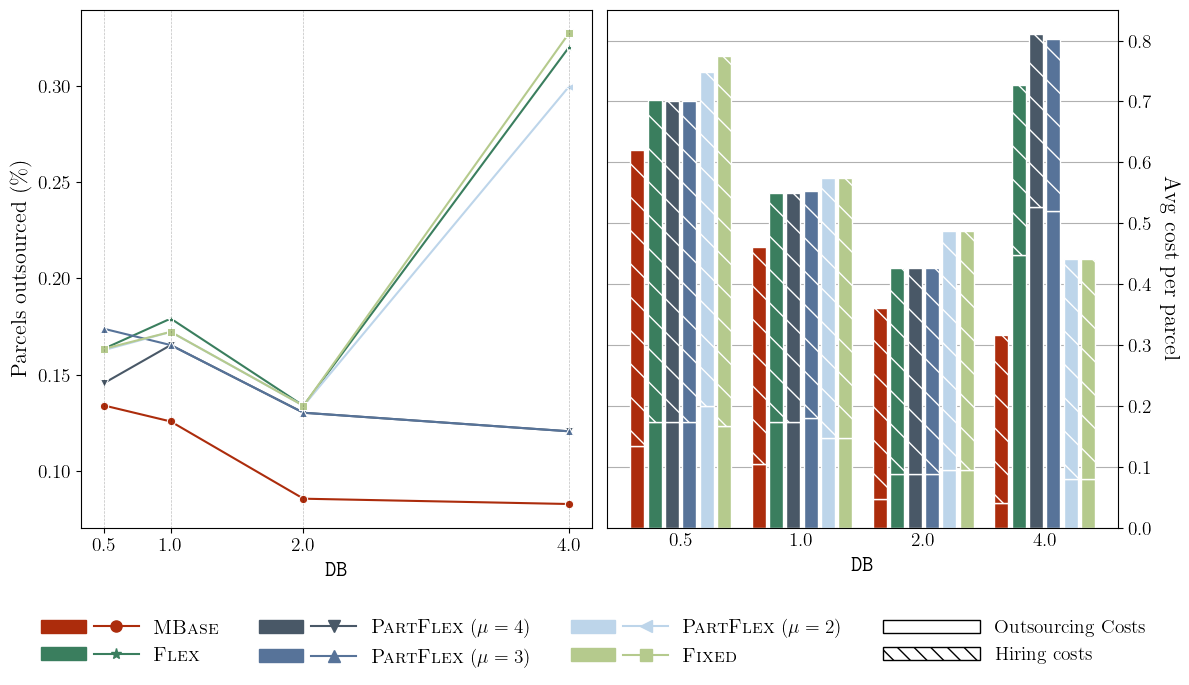

In [24]:
plot_db_impact()

## By OC multiplier

In [25]:
def plot_oc_impact():
    plt.rcParams['hatch.linewidth'] = 1

    oc_values = [1.2, 1.5, 1.8, 2.0, 2.5]
    models = ['baseline', 'flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

    ax = axes.flat[0]

    sns.lineplot(
        data=results_df, x='outsourcing_cost_multiplier', y='outsourcing_percentage',
        hue='model', style='model',
        errorbar=None, markers=markers, dashes=False, ax=ax , palette=sns.color_palette())
    ax.legend().set_visible(False)
    ax.axes.set_axisbelow(True)
    ax.axes.set_xticks(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16)
    ax.set_ylabel('Parcels outsourced (\\%)', fontsize=16)

    for oc in oc_values:
        ax.axvline(x=oc, linestyle='--', color='black', linewidth=0.5, alpha=0.25)

    ax = axes.flat[1]

    n_models = 6
    n_oc = len(oc_values)

    ticks = [(x1 + x2) / 2 for x1, x2 in zip(range(1, n_oc* n_models, n_models + 1), range(n_models, n_oc * (n_models + 1), n_models + 1))]

    for oc_idx, oc_val in enumerate(oc_values):
        for model_idx, model_long in enumerate(models):
            bar_x = oc_idx * (n_models + 1) + model_idx + 1
            data = results_df[(results_df['outsourcing_cost_multiplier'] == oc_val) & (results_df['model'] == model_long)]
            hc = data['wage_cost_per_package'].mean()
            oc = data['outsourcing_per_package'].mean()

            ax.bar(x=[bar_x], height=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white')
            ax.bar(x=[bar_x], height=[hc], bottom=[oc], color=f"C{model_idx}", linewidth=1, edgecolor='white', hatch='\\')


    ax.set_xticks(ticks)
    ax.set_xticklabels(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16)
    ax.yaxis.tick_right()
    ax.set_ylabel('Avg cost per parcel', rotation=270, labelpad=20, fontsize=16)
    ax.yaxis.set_label_position('right')
    ax.yaxis.grid(which='major')
    ax.set_axisbelow(True)
    ax.tick_params(which='major', axis='x', length=0)

    for ax in axes.flat:
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

    add_fig_legend(fig, bbox_to_anchor=(0.5, -0.15))

    fig.tight_layout()
    fig.savefig('figures/oc.pdf', dpi=96, bbox_inches='tight')

    return fig, axes

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: xlabel='\\texttt{OC}', ylabel='Parcels outsourced (\\%)'>,
        <Axes: xlabel='\\texttt{OC}', ylabel='Avg cost per parcel'>],
       dtype=object))

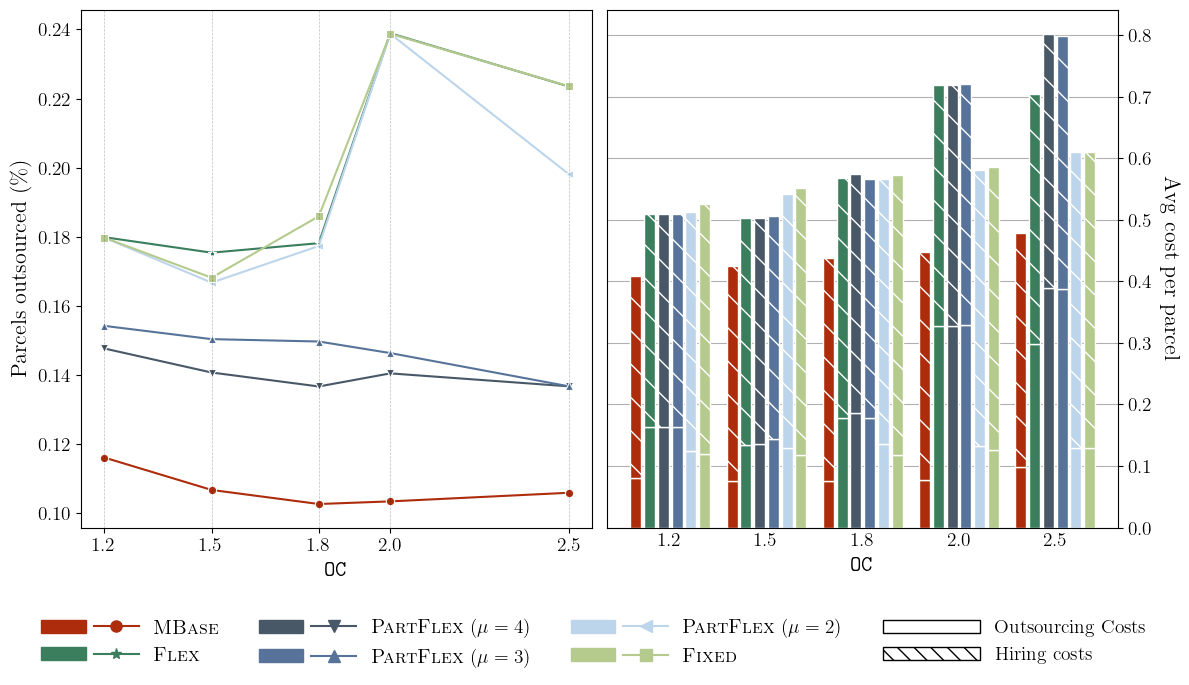

In [26]:
plot_oc_impact()